# Parte III: Entrenamiento de un modelo

Autor: Christian Torres

En este cuaderno, nos centraremos en cómo entrenar diferentes modelos de aprendizaje automático con el conjunto de datos que hemos preparado. Por ahora, nos olvidaremos de la validación cruzada y las pruebas, y nos centraremos únicamente en las particularidades de cada método para familiarizarnos con los enfoques clásicos del aprendizaje automático.

```{note}
Antes de ejecutar este notebook, asegúrese de que el kernel de Jupyter (esquina superior izquierda del notebook) se haya configurado para funcionar con el entorno que tienen instalada todas las librerías y dependencias.
```


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## 3.1 Configuración

En este punto, `df_all` tiene todos los datos que necesitaremos para entrenar, validar y probar el modelo. Sin embargo, antes de avanzar para entrenar un modelo de aprendizaje automático con estos datos, necesitamos separar una parte del conjunto de datos para probar el modelo y asegurarnos de que no estamos sobreajustando el modelo.

Para las pruebas, podemos usar diferentes estrategias:
1. Separar todos los datos para un conjunto determinado de estaciones y usar el resto para el entrenamiento/validación

1. Separar todos los datos para un conjunto determinado de estaciones en el período [yyyy-yyyy] y usar el resto para el entrenamiento/validación

1. Separar todos los datos para un conjunto determinado de estaciones en el período [yyyy-yyyy] y usar todas las mediciones para el resto de los estaciones y el otro período [yyyy-yyyy] para el entrenamiento/validación.

Dado que este conjunto de datos es muy rico *temporalmente*, lo vamos a dividir en esa dimensión en lugar de en la *espacial*. De este modo, intentaremos predecir los cambios de temperatura del aire solo para la estación meteorológica para el periodo que no hemos "visto" ninguna observación.

Leemos el conjunto de datos previamente almacenado con la matriz de características y los datos de destino.

In [32]:
#df_all = pd.read_csv('../data/df_all.csv', index_col=['Datetime'],parse_dates=['Datetime'])
df_all = pd.read_csv('../data/df_all.csv', index_col=['time'],parse_dates=['time'])

df_all 


,t2m,z,tp,g_1000,t_1000,g_500,t_500,g_200,t_200,Temp
time,,,,,,,,,,
2014-01-01 06:00:00,277.90180,37063.72,0.000000,0.007724,296.93036,0.002321,267.87152,0.000031,221.52385,11.200000
2014-01-01 12:00:00,279.36935,37063.72,0.000000,0.007367,297.06238,0.002287,268.74133,0.000030,221.22790,17.150000
2014-01-01 18:00:00,285.01968,37063.72,0.000739,0.008523,297.13602,0.003990,268.28558,0.000041,221.73782,22.366667
2014-01-02 00:00:00,279.97020,37063.72,0.000187,0.008609,297.24298,0.003992,269.07202,0.000092,222.62428,14.716667
2014-01-02 06:00:00,278.92530,37063.72,0.000007,0.008257,296.93176,0.003964,268.45926,0.000030,222.50063,12.950000
...,...,...,...,...,...,...,...,...,...,...
2018-12-11 18:00:00,283.42606,37063.72,0.001960,0.009002,296.80660,0.003822,267.47552,0.000086,219.55948,23.470000
2018-12-12 00:00:00,281.88910,37063.72,0.000050,0.007484,297.16144,0.003705,267.70605,0.000075,219.33456,15.711667
2018-12-12 06:00:00,279.94855,37063.72,0.000060,0.007501,296.70740,0.003792,266.72250,0.000071,218.78412,11.350000


### Separación entre entrenamiento y prueba

Ahora debemos dividir nuestro conjunto de datos en entrenamiento y prueba. Vamos a conservar el 70 % de los glaciares para el entrenamiento y el 30 % para la prueba. Es muy importante NO utilizar el conjunto de datos de prueba hasta el final de nuestro entrenamiento, una vez que estemos seguros de haber encontrado los mejores hiperparámetros.


In [33]:
df_train, df_test = train_test_split(df_all, 
                                     train_size=0.3,
                                     test_size=0.7)

df_train.shape, df_test.shape

((1728, 10), (4035, 10))

In [34]:
#df_train = df_all.loc['20140101': '20161231']
#df_test  = df_all.loc['20170101': '20181231']
#df_train.shape, df_test.shape

Guardamos el conjunto de datos de prueba en un archivo para poder guardarlo.

In [35]:
df_test.to_csv('../data/df_test.csv')
df_train.to_csv('../data/df_train.csv')

### Separación entre validación y entrenamiento

Ahora vamos a entrenar los modelos basándonos en el conjunto de datos de entrenamiento, que tendremos que dividir de nuevo en entrenamiento y validación. Como recordatorio, el conjunto de datos de entrenamiento se dará a los modelos de aprendizaje automático para que se ajusten a los datos, y el conjunto de datos de validación se dejará a un lado, con el fin de ajustar los hiperparámetros del modelo para que se ajusten mejor al conjunto de datos de validación fuera de muestra. Esto se hace para evitar el sobreajuste y para seleccionar un conjunto de hiperparámetros del modelo que generalicen mejor los datos no vistos. 

Una forma sencilla e ingenua de hacerlo es dividir en un 80% para el entrenamiento y un 20% para la validación. Tenga en cuenta que aquí el nuevo conjunto de datos de entrenamiento es sólo un subconjunto del conjunto de datos de entrenamiento anterior. A partir del conjunto de datos original, hemos dividido las cosas de la siguiente manera:

Conjunto de datos completo:
* Conjunto de datos de prueba -> separado
* Conjunto de datos de entrenamiento -> dividido en entrenamiento/validación

    + Conjunto de datos de validación -> utilizado para la selección de hiperparámetros
    + Conjunto de datos de entrenamiento -> conjunto de datos de entrenamiento real alimentado a los diferentes modelos de aprendizaje automático

Por ahora, dividiremos el conjunto de datos en un 80% de entrenamiento y un 20% de prueba.

In [36]:
df_train, df_validation = train_test_split(df_train, 
                                           train_size=0.8,
                                           test_size=0.2)

df_train.shape, df_validation.shape

((1382, 10), (346, 10))

Y ahora tenemos que separar la matriz de características ($X$) de los datos de destino ($Y$), ya que tienen que ser alimentados por separado a los modelos. Esto nos dará 4 conjuntos de datos diferentes:
- Conjuntos de datos de entrenamiento:
    - `X_entrenamiento`
    - `y_entrenamiento`
- Conjuntos de datos de validación:
    - `X_validación`
    - `y_Validación`

In [37]:
features_to_drop = ['Temp', 'z', 'tp']

df_train_X = df_train.drop(features_to_drop, axis=1)
df_train_y = df_train[['Temp']]

X_train, y_train = df_train_X.values, df_train_y.values

# Y lo mismo para el conjunto de pruebas
df_validation_X = df_validation.drop(features_to_drop, axis=1)
df_validation_y = df_validation[['Temp']]

X_validation, y_validation = df_validation_X.values, df_validation_y.values

In [38]:
df_train_X

,t2m,g_1000,t_1000,g_500,t_500,g_200,t_200
time,,,,,,,
2018-01-23 18:00:00,285.58002,0.011625,297.28998,0.002942,267.00192,0.000045,219.38904
2015-12-16 12:00:00,279.37958,0.008288,296.73914,0.002894,267.28440,0.000047,220.90002
2018-05-19 06:00:00,276.94913,0.007013,297.03293,0.002849,267.50348,0.000019,218.38457
2016-03-13 00:00:00,281.08987,0.009882,297.12494,0.003886,269.84192,0.000058,221.92384
2018-03-20 00:00:00,278.94916,0.008650,297.31235,0.004218,269.16037,0.000091,220.54022
...,...,...,...,...,...,...,...
2018-05-22 18:00:00,284.85410,0.007012,296.99380,0.004436,268.22992,0.000022,219.75227
2015-03-17 06:00:00,278.91742,0.008800,297.04443,0.004597,268.43640,0.000073,219.09073
2015-12-11 06:00:00,278.76855,0.008629,296.55255,0.003755,268.62723,0.000020,220.89578


## 3.2 Entrenamiento de un modelo 

El paquete `sklearn` incluye múltiples modelos de regresión que podemos probar en el conjunto de datos. Una de las ventajas de usar `sklearn` es que la sintaxis y la lógica es compartida entre diferentes algoritmos, lo que facilita probar y comparar diferentes modelos. La [documentación de sklearn](https://scikit-learn.org/stable/auto_examples/index.html#examples) incluye varios de estos ejemplos que merece la pena explorar. 

Algunos métodos de regresión a explorar incluyen

1. Enfoques clásicos de regresión continua: regresión lineal, regresión logística, máquinas de vectores soporte.

1. Regresión basada en árboles: árboles de decisión, bosque aleatorio, métodos ensemble basados en boosting.

1. Redes neuronales.

La siguiente función gráfica será útil para informar del rendimiento de los distintos modelos.

In [39]:
def plot_prediction(y1, y2, n_toplot=10**10):
    
    from scipy.stats import gaussian_kde
    from sklearn.metrics import r2_score, mean_squared_error
    
    idxs = np.arange(len(y1))
    np.random.shuffle(idxs)
    
    y_expected = y1.reshape(-1)[idxs[:n_toplot]]
    y_predicted = y2.reshape(-1)[idxs[:n_toplot]]

    xy = np.vstack([y_expected, y_predicted])
    z = gaussian_kde(xy)(xy)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    y_plt, ann_plt, z = y_expected[idx], y_predicted[idx], z[idx]
    
    plt.figure(figsize=(8,8))
    plt.title("Evaluación de model", fontsize=17)
    plt.ylabel('T2 modelado (°C)', fontsize=16)
    plt.xlabel('T2 referencia (°C)', fontsize=16)
    sc = plt.scatter(y_plt, ann_plt, c=z, s=20)
    plt.clim(0,0.4)
    plt.tick_params(labelsize=14)
    plt.colorbar(sc) 
    lineStart = 5
    lineEnd =   30
    plt.plot([lineStart, lineEnd], [lineStart, lineEnd], 'k-')
    plt.axvline(0.0, ls='-.', c='k')
    plt.axhline(0.0, ls='-.', c='k')
    plt.xlim(lineStart, lineEnd)
    plt.ylim(lineStart, lineEnd)
    plt.gca().set_box_aspect(1)
    
    textstr = '\n'.join((
    r'$RMSE=%.2f$' % (mean_squared_error(y_expected, y_predicted), ),
    r'$R^2=%.2f$' % (r2_score(y_expected, y_predicted), )))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    # place a text box in upper left in axes coords
    plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    plt.show()

### 3.2.1. Regresión lineal

La regresión lineal es el tipo de regresión más básico que podemos utilizar en nuestro conjunto de datos. Por lo tanto, representa el modelo de referencia con el que comparar el resto. En esta sección utilizaremos `ElasticNet`, una regresión lineal con términos de regularización combinados $L_1$ y $L_2$.

```{nota}
Si desea comprender mejor la regresión lineal y la regularización, le recomiendo echar un vistazo a [este Cuaderno](https://github.com/Machine-Learning-in-Glaciology-Workshop/Lecture-materials/blob/main/Stats/linear_regression.ipynb) que Ellie Abrahams preparó para este taller de glaciologia en Noruega.
```

In [40]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet

Para la regresión lineal y muchos otros métodos, escalaremos los datos para que tengan media cero y varianza unitaria.

In [41]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [42]:
X_train_scaled = scaler.transform(X_train)
X_validation_scaled = scaler.transform(X_validation)

ElasticNet es un modelo de regresión lineal que incluye el clásico estimador de error mínimo cuadrático ordinario (`alpha=0.0`), Lasso (`l1_ratio=1`) y regresión Ridge (`l1_ratio=0`) en un único método. 

En este caso, vamos a ajustar un modelo `ElasticNet` a nuestro conjunto de datos de entrenamiento, con los siguientes hiperparámetros.

In [43]:
%time
reg_linear = ElasticNet(alpha=0.001,
                        l1_ratio=0.8,
                        fit_intercept=True, 
                        random_state=666)
reg_linear.fit(X_train_scaled, y_train)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.3 µs


ElasticNet(alpha=0.001, l1_ratio=0.8, random_state=666)

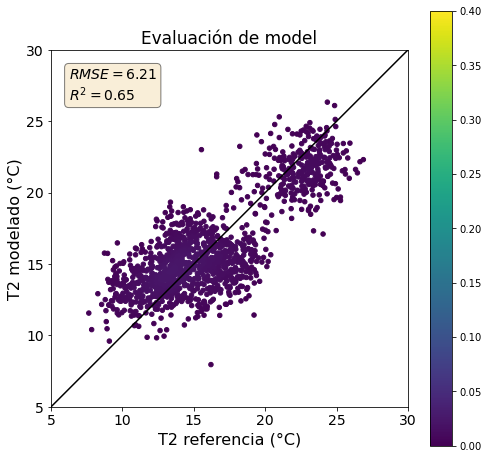

In [44]:
plot_prediction(y_train, reg_linear.predict(X_train_scaled), n_toplot=5000)

Podemos ver que el rendimiento no es muy bueno, ya que no hemos hecho ninguna selección de hiperparámetros. Dejaremos eso para el siguiente cuaderno, y aquí sólo nos centraremos en tener una visión general de todos los métodos y sus hiperparámetros particulares. 

### 3.2.2. Regresión del árbol de decisión

Los árboles de decisión son métodos no paramétricos de aprendizaje supervisado. El objetivo de este método es generar un modelo que prediga el valor de una variable objetivo mediante el aprendizaje de reglas de decisión sencillas inferidas a partir de las características de los datos. Un árbol puede verse como una aproximación constante a trozos.

Para más detalles, puede leer la [documentación de `sklearn`](https://scikit-learn.org/stable/modules/tree.html#tree). 

In [45]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

Por ahora, sólo rellenaremos algunos de los hiperparámetros para ver cómo se comporta. 

In [46]:
%%time
reg_tree = DecisionTreeRegressor(random_state=0, 
                                 max_depth=5, 
                                 min_samples_split=5)
reg_tree.fit(X_train, y_train)

CPU times: user 5.09 ms, sys: 4.19 ms, total: 9.28 ms
Wall time: 12.5 ms


DecisionTreeRegressor(max_depth=5, min_samples_split=5, random_state=0)

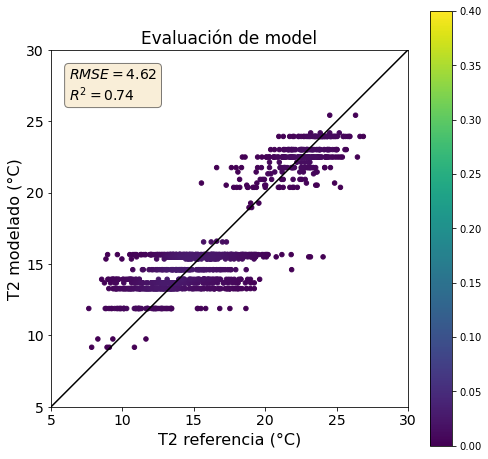

In [47]:
plot_prediction(y_train, reg_tree.predict(X_train), n_toplot=5000)

De nuevo, podemos ver que el rendimiento no es nada bueno, ya que todavía tenemos que hacer una búsqueda adecuada de hiperparámetros. 

### 3.2.3. Ensemble de árboles

Podemos probar ejemplos de modelos que combinan aprendizajes lentos. Estos modelos suelen funcionar muy bien y ser bastante generales. Sin embargo, afinar los diferentes hiperparámetros del modelo puede ser complicado. 

Estos métodos son [particularmente potentes para datos tabulares](https://arxiv.org/abs/2207.08815), el tipo exacto de datos que tenemos en este proyecto. Utilizaremos dos de los mejores métodos de conjunto de árboles: Random Forest y Gradient Boosting. Aquí puedes encontrar un ejemplo basado en [Gradient boosting regression](https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html#sphx-glr-auto-examples-ensemble-plot-gradient-boosting-regression-py).

In [48]:
from sklearn import ensemble
from sklearn.inspection import permutation_importance

Como se puede ver, aquí empezamos a tener una mayor cantidad de hiperparámetros. Por lo tanto, hacer una buena selección de hiperparámetros será crucial para que estos métodos se ajusten correctamente a los datos en la validación. 

In [49]:
model = 'random forest'
#model = 'gradient boosting'

if model == 'gradient boosting':

    params = {
        "n_estimators": 300,
        "max_depth": 4,
        "min_samples_split": 5,
        "learning_rate": 0.1,
        "loss": 'huber', #"squared_error",
        "validation_fraction": 0.2
    }
    reg_ensemble = ensemble.GradientBoostingRegressor(**params)
    
elif model == 'random forest':
    
    params = {
        "n_estimators": 300,
        "max_depth": 4,
        "min_samples_split": 5,
        "criterion": "absolute_error",
        'max_features': 0.8,
    }
    reg_ensemble = ensemble.RandomForestRegressor(**params)

In [50]:
%%time
reg_ensemble.fit(X_train, y_train)

<timed eval>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


CPU times: user 10.1 s, sys: 15.5 ms, total: 10.1 s
Wall time: 10.1 s


RandomForestRegressor(criterion='absolute_error', max_depth=4, max_features=0.8,
                      min_samples_split=5, n_estimators=300)

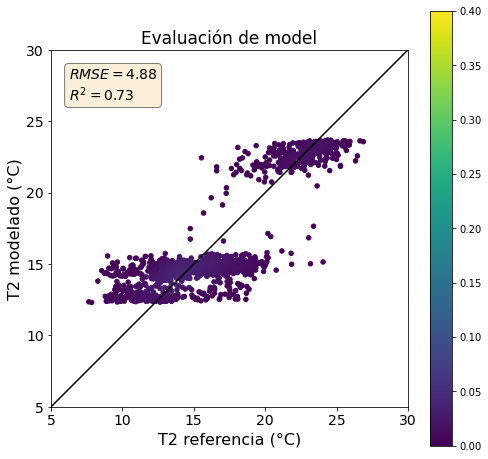

In [51]:
plot_prediction(y_train, reg_ensemble.predict(X_train), n_toplot=5000)

Para este caso, los resultados por defecto no son tan malos, pero podrían mejorarse con una búsqueda de hiperparámetros. 

Otro aspecto interesante de los métodos basados en árboles es su interpretabilidad. Es bastante fácil extraer la importancia de los rasgos y la importancia de las permutaciones, lo que puede darnos pistas importantes sobre la contribución de cada rasgo (y, por tanto, de las distintas variables de forzamiento) a la determinación de la temperatura en la estación meteorologica.

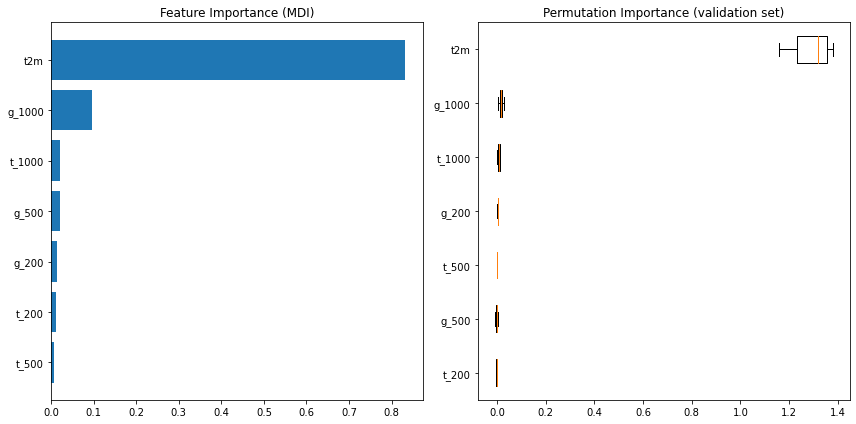

In [52]:
feature_importance = reg_ensemble.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(df_validation_X.columns)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    reg_ensemble, X_validation, y_validation, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(df_validation_X.columns)[sorted_idx],
)
plt.title("Permutation Importance (validation set)")
fig.tight_layout()
plt.show()

### 3.2.4. Redes neurales

Las redes neurales son uno de los métodos de aprendizaje automático más potentes que existen. Sin embargo, son mucho más difíciles de calibrar, debido al gran número de hiperparámetros, opciones de arquitectura y el hecho de que también tienen parámetros (pesos) que necesitan ser entrenados de forma iterativa utilizando el descenso de gradiente. 

En este caso, utilizaremos la más sencilla de las redes neuronales, un perceptrón multicapa clásico con una arquitectura pequeña de dos capas ocultas. Seguiremos utilizando `sklearn` para ello, aunque para modelados más serios recomiendo encarecidamente utilizar librerías dedicadas más avanzadas como JAX, PyTorch o Keras/Tensorflow.

In [53]:
from sklearn.neural_network import MLPRegressor

Estos son algunos de los hiperparámetros que `sklearn` nos permite elegir para la red neuronal. Utilizamos una arquitectura pequeña `(50,30,20,10)`, una función de activación `ReLu`, un optimizador LBFGS (generalmente mejor que ADAM para redes pequeñas), un tamaño de lote de 100, 200 épocas de entrenamiento, y barajamos los lotes para mejorar el aprendizaje. 

Tenga en cuenta que `sklearn` también nos permite elegir una fracción del conjunto de datos que se utilizará para la validación para establecer una parada temprana (es decir, detener el entrenamiento una vez que vemos que la pérdida ya no disminuye para un número determinado de épocas). 

In [54]:
reg_nn = MLPRegressor(hidden_layer_sizes=(50,30,20,10),
                      activation='relu',
                      solver='lbfgs', 
                      batch_size=100, 
                      max_iter=200,
                      learning_rate='adaptive', 
                      shuffle=True, 
                      validation_fraction=0.1)

In [55]:
%%time
reg_nn.fit(X_train_scaled, y_train)

/home/christian/miniconda3/envs/DL_SMB/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 5.06 s, sys: 2.83 s, total: 7.9 s
Wall time: 2.79 s


/home/christian/miniconda3/envs/DL_SMB/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPRegressor(batch_size=100, hidden_layer_sizes=(50, 30, 20, 10),
             learning_rate='adaptive', solver='lbfgs')

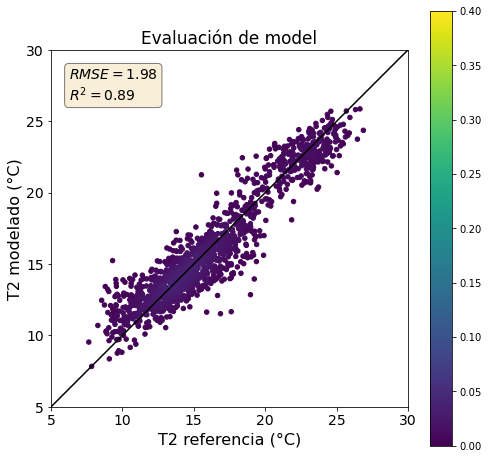

In [56]:
plot_prediction(y_train, reg_nn.predict(X_train_scaled), n_toplot=5000)

Al igual que para los métodos basados en árboles, podemos ver que esta red neural, incluso con un ajuste menor de los hiperparámetros, ya es bastante capaz de modelizar la variabilidad del balance de masa de todo el glaciar para el conjunto de datos de entrenamiento. Ahora tenemos que asegurarnos de que también es capaz de extrapolar correctamente a los periodos "invisibles" del conjunto de datos de prueba.

### Guardar el modelo IA

In [57]:
import pickle

In [58]:
with open('../model/reg_linear.pkl','wb') as f:
    pickle.dump(reg_linear,f)

with open('../model/reg_ensemble.pkl','wb') as f:
    pickle.dump(reg_ensemble,f)

with open('../model/reg_nn.pkl','wb') as f:
    pickle.dump(reg_nn,f)



### [ **Ejercicio 2** ]

<img src="img/eye_logo.png" width="75"/>

Elija 2 o 3 modelos ML diferentes y juegue con los hiperparámetros para mejorar el rendimiento **en validación** observando el gráfico de dispersión. Sólo tienes que reproducir el mismo flujo de trabajo, pero utilizando el conjunto de datos de validación para visualizar los resultados en lugar del de entrenamiento. 

Esto es sólo una forma aproximada de tener una primera estimación de buenos hiperparámetros. En el próximo cuaderno veremos cómo buscar correctamente los mejores hiperparámetros posibles utilizando la validación cruzada. 